In [117]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import torchvision as tv

import numpy as np
from numpy.typing import NDArray
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

In [ ]:
class Dataset2Classes(torch.utils.data.Dataset[Tuple[cv2.typing.MatLike, int]]):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir_list1 = sorted(os.listdir(path_dir1))
        self.dir_list2 = sorted(os.listdir(path_dir2))
        
    def __len__(self) -> int:
        return len(self.dir_list1) + len(self.dir_list2)
    
    def __getitem__(self, index:int) -> Tuple[cv2.typing.MatLike, int]:
        if (index < len(self.dir_list1)):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir_list1[index])
        else:
            class_id = 1
            img_path = os.path.join(self.path_dir2, self.dir_list2[index - len(self.dir_list1)])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_AREA)
        img_typed: NDArray[np.float32] = img.astype(np.float32)
        img_typed = img_typed / 255.0
        img_typed = img_typed.transpose([2, 0, 1])

        t_img = torch.from_numpy(img_typed)
        t_class_id = torch.tensor(class_id)
        
        return { 'img': t_img, 'label': t_class_id }

In [ ]:
train_cats_path = './data/train/cats'
train_dogs_path = './data/train/dogs'
test_cats_path = './data/test/cats'
test_dogs_path = './data/test/dogs'

train_ds_catsdogs = Dataset2Classes(
    train_cats_path,
    train_dogs_path,
)
test_ds_catsdogs = Dataset2Classes(
    test_cats_path,
    test_dogs_path,
)

In [120]:
len(test_ds_catsdogs)

138

In [121]:
batch_size = 10

train_loader = torch.utils.data.DataLoader(
	train_ds_catsdogs,
 	batch_size=batch_size,
  	num_workers=1,
	shuffle=True,
	drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
	test_ds_catsdogs,
 	batch_size=batch_size,
  	num_workers=1,
	shuffle=True,
	drop_last=False,
)

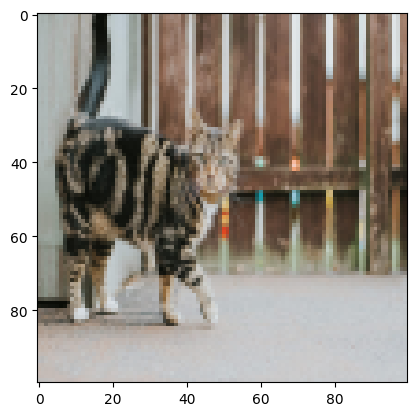

In [127]:
plt.imshow(train_ds_catsdogs[0]['img'].permute(1, 2, 0).numpy())

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2) #!
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten() #!
        self.linear1 = nn.Linear(32, 10) #!
        self.linear2 = nn.Linear(10, 2) #!
        
        
    def forward(self, x: torch.Tensor):
        out = self.conv0(x)
        out = self.act(out)
        
        out = self.conv1(out)
        out = self.act(out)
        
        out = self.conv2(out)
        out = self.act(out)
        
        out = self.conv3(out)
        out = self.act(out)
        
        out = self.conv4(out)
        out = self.act(out)
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out
        

In [93]:
model = ConvNet()

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [95]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    
    return answer.mean()

In [96]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [97]:
count_parameters(model)

38240

In [128]:
epochs = 10

for epoch in range(epochs):
    loss_value = 0
    acc_value = 0
    
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        optimizer.zero_grad()
        
        label = F.one_hot(label, 2).float()
        pred = model(img)
        
        loss = loss_fn(pred, label)
        
        loss.backward()
        loss_item = loss.item()
        loss_value += loss_item
        
        optimizer.step()
        
        acc_current = accuracy(pred, label)
        acc_value += acc_current
        
        pbar.set_description(f'loss: {loss_item:.4e}\taccuracy: {acc_current:.4e}')
    
    print(loss_value / len(train_loader))
    print(acc_value / len(train_loader))

  0%|          | 0/55 [00:00<?, ?it/s]/tmp/ipykernel_159949/3800270976.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 6.7311e-01	accuracy: 6.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.80it/s]


0.688811310854825
0.6018181818181818


loss: 6.9474e-01	accuracy: 5.0000e-01: 100%|██████████| 55/55 [00:08<00:00,  6.29it/s]


0.6864351651885293
0.5709090909090909


loss: 6.5695e-01	accuracy: 7.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.99it/s]


0.6800678599964488
0.58


loss: 7.0967e-01	accuracy: 5.0000e-01: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]


0.6790414615110918
0.5690909090909091


loss: 6.7179e-01	accuracy: 6.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.68it/s]


0.6698307416655801
0.5945454545454544


loss: 6.6706e-01	accuracy: 6.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.85it/s]


0.6688576579093933
0.5745454545454548


loss: 6.4570e-01	accuracy: 7.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.76it/s]


0.6741906220262701
0.58


loss: 5.8492e-01	accuracy: 8.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.70it/s]


0.6658355777913874
0.6127272727272727


loss: 6.1247e-01	accuracy: 7.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.90it/s]


0.6631194125522267
0.6072727272727274


loss: 6.8032e-01	accuracy: 6.0000e-01: 100%|██████████| 55/55 [00:09<00:00,  5.82it/s]

0.6631222053007646
0.609090909090909


In [ ]:
img = cv2.imread('./uploads/dog_test.jpg', cv2.IMREAD_COLOR)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

img = img.astype(np.float32) / 255.0
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

test_img = torch.from_numpy(img)

with torch.no_grad():
    test_pred = model(test_img)
    predicted_class = torch.argmax(test_pred, dim=1).item()



In [135]:
print("Predicted class:", predicted_class)

Predicted class: 1
